In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def cblock(filters,kernel_size,dd,route,training,strides):
  # Performs Convolution action with given number of filters and square kernels of given width
  if strides>1:
    inputs = padding(inputs=route, kernel_size=kernel_size, data_format=dd)            
  else:
    inputs=route
  inputs = tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides, padding=('SAME' if strides == 1 else 'VALID'), use_bias=False, data_format=dd)
  inputs = tf.layers.batch_normalization(inputs=inputs, axis=1 if dd == 'channels_first' else 3,momentum=momentum,scale=True, training=training)
  inputs = tf.nn.leaky_relu(inputs,alpha=alpha )

  return inputs

In [3]:
def detect(inputs,filters,training,data_format,n_classes,anchors,model_size):
  route, inputs = yolo_convolution_block(
                inputs, filters, training=training,
                data_format=data_format)
  detect1 = yolo_layer(inputs, n_classes=n_classes, anchors=anchors, img_size=model_size, data_format=data_format)
  return route,inputs,detect1

In [4]:
def con_up(filters,kernel_size,df,route,training,strides,route2):
  inputs = cblock(filters,kernel_size,dd=df,route=route,training=training,strides=strides)
  upsample_size = route2.get_shape().as_list()
  inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=df)
  return inputs

In [5]:
#Defining parameters of the model
momentum = 0.9
epsilon = 1e-05
alpha = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)


def padding(inputs, kernel_size, data_format):
    #Pads the given input tensor
    #kernel_size is the size of kernel to be used in the conv2d or max_pool2d
    #A padded tensor with the same format as input is outputted
    pad_total = kernel_size - 1
    start = pad_total // 2
    end = pad_total - start

    if data_format == 'channels_first':
        padded = tf.pad(inputs, [[0, 0], [0, 0],[start, end],[start, end]])

    else:
        padded = tf.pad(inputs, [[0, 0], [start, end],[start, end], [0, 0]])

    return padded


def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
#Creating a residual block for Darknet
  
    shortcut = inputs
    # Performs Convolution action with Number of filters= filters with kernel Size = (1 * 1)
    inputs = cblock(filters,kernel_size=1,dd=data_format,route=inputs,training=training,strides=1)

    # Performs Convolution action with Number of filters=2* filters  with kernel Size = (3 * 3)
    inputs = cblock(filters=2*filters,kernel_size=3,dd=data_format,route=inputs,training=training,strides=1)

    inputs += shortcut

    return inputs


def darknet53(inputs, training, data_format):
# Creates Darknet53 model for feature extraction.

    # Performs Convolution action with Number of filters= 32 with kernel Size = (3 * 3)    
    inputs = cblock(filters=32,kernel_size=3,dd=data_format,route=inputs,training=training,strides=1)

    # Performs Convolution action with Number of filters= 64 with kernel Size = (3 * 3)
    inputs = cblock(filters=64,kernel_size=3,dd=data_format,route=inputs,training=training,strides=2)

    # Performs Convolution action with Number of filters= 32 with kernel Size = (1 * 1)
    # Performs Convolution action with Number of filters= 64 with kernel Size = (3 * 3)
    # Residual Action
    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    # Performs Convolution action with Number of filters= 128 with kernel Size = (3 * 3)
    inputs = cblock(filters=128,kernel_size=3,dd=data_format,route=inputs,training=training,strides=2)

    # Performs Convolution action with Number of filters= 64 with kernel Size = (1 * 1)
    # Performs Convolution action with Number of filters= 128 with kernel Size = (3 * 3) 
    # Residual Action
    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)
    
    # Performs Convolution action with Number of filters= 256 with kernel Size = (3 * 3)
    inputs = cblock(filters=256,kernel_size=3,dd=data_format,route=inputs,training=training,strides=2)
 
    # Performs Convolution action with Number of filters= 128 with kernel Size = (1 * 1)
    # Performs Convolution action with Number of filters= 256 with kernel Size = (3 * 3)
    # Residual Action
    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    # Performs Convolution action with Number of filters= 512 with kernel Size = (3 * 3)
    inputs = cblock(filters=512,kernel_size=3,dd=data_format,route=inputs,training=training,strides=2)
    
    # Performs Convolution action with Number of filters= 256 with kernel Size = (1 * 1)
    # Performs Convolution action with Number of filters= 512 with kernel Size = (3 * 3)
    # Residual Action
    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    # Performs Convolution action with Number of filters= 1024 with kernel Size = (3 * 3)
    inputs = cblock(filters=1024,kernel_size=3,dd=data_format,route=inputs,training=training,strides=2)

    # Performs Convolution action with Number of filters= 512 with kernel Size = (1 * 1)
    # Performs Convolution action with Number of filters= 1024 with kernel Size = (3 * 3)
    # Residual Action
    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs


def yolo_convolution_block(inputs, filters, training, data_format):
    #Creates convolution operations layer used after Darknet
    inputs = cblock(filters=filters,kernel_size=1,dd=data_format,route=inputs,training=training,strides=1)

    inputs = cblock(filters=2*filters,kernel_size=3,dd=data_format,route=inputs,training=training,strides=1)
    inputs = cblock(filters=filters,kernel_size=1,dd=data_format,route=inputs,training=training,strides=1)

    inputs = cblock(filters=2*filters,kernel_size=3,dd=data_format,route=inputs,training=training,strides=1)

    inputs = cblock(filters=filters,kernel_size=1,dd=data_format,route=inputs,training=training,strides=1)

    route = inputs

    inputs = cblock(filters=2*filters,kernel_size=3,dd=data_format,route=inputs,training=training,strides=1)

    return route, inputs


def yolo_layer(inputs, n_classes, anchors, img_size, data_format):
    # Creates Yolo final detection layer
    # Detects boxes with respect to anchors
    # inputs: Tensor input
    # n_classes: Number of labels
    # anchors: A list of anchor sizes
    # img_size: The input size of the model
    # data_format: The input format

    n_anchors = len(anchors)

    inputs = tf.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)

    shape = inputs.get_shape().as_list()
    if data_format == 'channels_first':
      grid_shape = shape[2:4]  
    else:
      #print("Yes")
      grid_shape=shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])
    # confidence gives the probability that the image belongs to a particular class.
    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides

    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchors)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)
    
    # Function returns a tensor output
    return inputs


def upsample(inputs, out_shape, data_format):
  #Upsamples to `out_shape` using nearest neighbor interpolation
  if data_format == 'channels_first':
    inputs = tf.transpose(inputs, [0, 2, 3, 1])
    new_height = out_shape[3]
    new_width = out_shape[2]
  else:
    
    new_height = out_shape[2]
    new_width = out_shape[1]

  inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))

  if data_format == 'channels_first':
    inputs = tf.transpose(inputs, [0, 3, 1, 2])

  return inputs


def build_boxes(inputs):
  #FInds  top left and bottom right points of the boxes
  center_x, center_y, width, height, confidence, classes = tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)
  top_left_x = center_x - width / 2
  top_left_y = center_y - height / 2
  bottom_right_x = center_x + width / 2
  bottom_right_y = center_y + height / 2

  boxes = tf.concat([top_left_x, top_left_y, bottom_right_x, bottom_right_y, confidence, classes], axis=-1)

  return boxes


def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
   #Performs non-max suppression separately for each class.
    #max output sixe is the maximum number of boxes to be selected for each class.
      #confidence_threshold: Threshold for the confidence score.
    #Returns:A list containing class-to-boxes dictionaries for each sample in the batch.
    
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        bboxes_d = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,[4, 1, -1],axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,boxes_conf_scores,max_output_size,iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                bboxes_d[cls] = class_boxes[:, :5]

        boxes_dicts.append(bboxes_d)

    return boxes_dicts


class Yolo_v3:
    """Yolo v3 model class."""

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):

        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'

        self.n_classes = n_classes
        self.model_size = model_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):

        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255
            df=self.data_format
            route1, route2, inputs = darknet53(inputs, training=training,
                                               data_format=df)

            route,inputs,detect1=detect(inputs,512,training,df,n_classes,_ANCHORS[6:9],self.model_size)

            inputs=con_up(256,1,df,route,training,1,route2)
            if df == 'channels_first':
              axis=1
            else:
              axis=3
            inputs = tf.concat([inputs, route2], axis=axis)
            route,inputs,detect2=detect(inputs,256,training,df,n_classes,_ANCHORS[3:6],self.model_size)

            inputs=con_up(128,1,df,route,training,1,route1)
            inputs = tf.concat([inputs, route1], axis=axis)

            route,inputs,detect3=detect(inputs,128,training,df,n_classes,_ANCHORS[0:3],self.model_size)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

In [6]:
#Utility functions. Not part of the YOLOv3 algo
def load_images(img_names, model_size):

    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img[:, :, :3], axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):

    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size,imgshape):
    talk=[]
    W=imgshape[0]
    H=imgshape[1]

    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='futur.ttf',size=(img.size[0] + img.size[1]) // 100)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 200
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    text = '{} {:.1f}%'.format(class_names[cls],
                                               confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle(
                        [x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)
                    
                    print(xy)
                    print('{} {:.2f}%'.format(class_names[cls],
                                              confidence * 100))
                    
                    centerx=(xy[0]+xy[2])/2
                    centery=(xy[1]+xy[3])/2
                    if centerx <= W/3:
                      W_pos = "left "
                    elif centerx <= (W/3 * 2):
                      W_pos = "center "
                    else:
                      W_pos = "right "
                    if centery <= H/3:
                      H_pos = "forward "
                    elif centery <= (H/3 * 2):
                      H_pos = "mid "
                    else:
                      H_pos = "immediate "


                    talk.append('There is a {} to your {}{}'.format(class_names[cls],
                                              H_pos,W_pos))

        rgb_img = img.convert('RGB')
        rgb_img.save('Result.jpg')
        return talk


def draw_frame(frame, frame_size, boxes_dicts, class_names, model_size):

    boxes_dict = boxes_dicts[0]
    resize_factor = (frame_size[0] / model_size[1], frame_size[1] / model_size[0])
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for cls in range(len(class_names)):
        boxes = boxes_dict[cls]
        color = colors[cls]
        color = tuple([int(x) for x in color])
        if np.size(boxes) != 0:
            for box in boxes:
                xy = box[:4]
                xy = [int(xy[i] * resize_factor[i % 2]) for i in range(4)]
                cv2.rectangle(frame, (xy[0], xy[1]), (xy[2], xy[3]), color[::-1], 2)
                (test_width, text_height), baseline = cv2.getTextSize(class_names[cls],
                                                                      cv2.FONT_HERSHEY_SIMPLEX,
                                                                      0.75, 1)
                cv2.rectangle(frame, (xy[0], xy[1]),
                              (xy[0] + test_width, xy[1] - text_height - baseline),
                              color[::-1], thickness=cv2.FILLED)
                cv2.putText(frame, class_names[cls], (xy[0], xy[1] - baseline),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 1)

In [7]:
def ass_ops(cvar,weights,ptr,trans,assign_ops):
  shape = cvar.shape.as_list()
  num_params = np.prod(shape)
  if trans==True:
    var_weights = weights[ptr:ptr + num_params].reshape((shape[3], shape[2], shape[0], shape[1]))
    var_weights = np.transpose(var_weights, (2, 3, 1, 0))
  else:
    var_weights = weights[ptr:ptr + num_params].reshape(shape)
  ptr += num_params
  assign_ops.append(tf.assign(cvar, var_weights))
  return ptr,assign_ops
def uploadweights(variables, file_name):
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            cvar = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                ptr,assign_ops=ass_ops(var,weights,ptr,trans=False,assign_ops=assign_ops)

            ptr,assign_ops=ass_ops(cvar,weights,ptr,trans=True,assign_ops=assign_ops)

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                cvar = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    ptr,assign_ops=ass_ops(var,weights,ptr,trans=False,assign_ops=assign_ops)

                ptr,assign_ops=ass_ops(cvar,weights,ptr,trans=True,assign_ops=assign_ops)

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            
            ptr,assign_ops=ass_ops(bias,weights,ptr,trans=False,assign_ops=assign_ops)
            cvar = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            ptr,assign_ops=ass_ops(cvar,weights,ptr,trans=True,assign_ops=assign_ops)

    return assign_ops

In [8]:
_MODEL_SIZE = (416, 416)
_CLASS_NAMES_FILE = 'coco.names'
_MAX_OUTPUT_SIZE = 20


def main(type, iou_threshold, confidence_threshold, input_names):
    class_names = load_class_names(_CLASS_NAMES_FILE)
    n_classes = len(class_names)

    model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                    max_output_size=_MAX_OUTPUT_SIZE,
                    iou_threshold=iou_threshold,
                    confidence_threshold=confidence_threshold)

    if type == 'images':
        batch_size = len(input_names)
        batch = load_images(input_names, model_size=_MODEL_SIZE)
        inputs = tf.placeholder(tf.float32, [batch_size, *_MODEL_SIZE, 3])
        detections = model(inputs, training=False)
        saver = tf.train.Saver(tf.global_variables(scope='yolo_v3_model'))

        with tf.Session() as sess:
            saver.restore(sess, './weights/model.ckpt')
            detection_result = sess.run(detections, feed_dict={inputs: batch})

        draw_boxes(input_names, detection_result, class_names, _MODEL_SIZE)

        print('Detections have been saved successfully.')

    else:
        raise ValueError("Inappropriate data type. Please choose 'images'.")

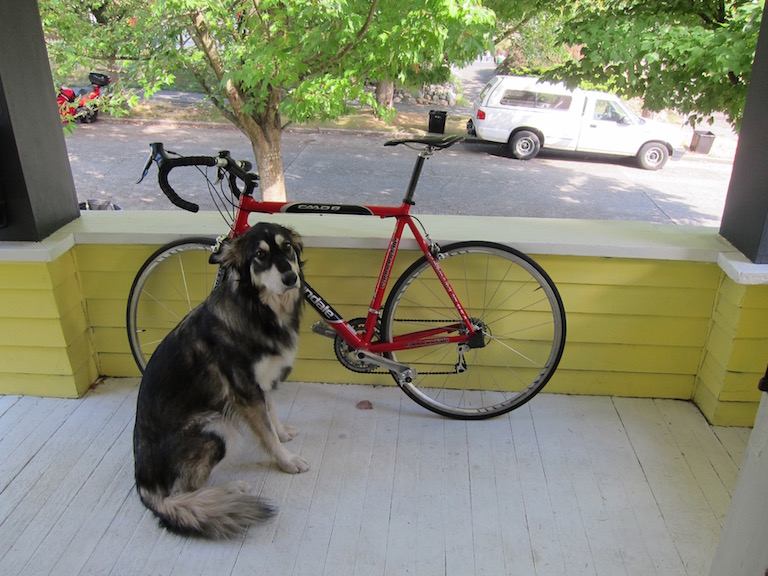

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  import sys
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use 

Instructions for updating:
Use `tf.cast` instead.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.


[117.35302734375, 131.190430861253, 569.3682016225962, 427.482661320613]
bicycle 99.10%
[475.1146615835337, 89.92323655348558, 688.8137019230769, 163.57597468449518]
truck 99.86%
[125.06365497295674, 227.7978304349459, 318.8715256911058, 539.3301156850962]
dog 99.99%


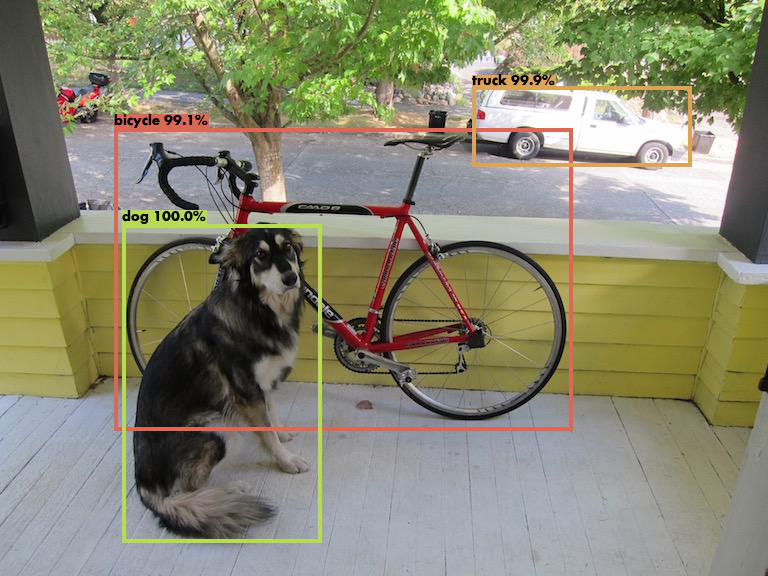

In [9]:
img_names = ['imageee.png']
for img in img_names: display(Image.open(img))

batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold,data_format = 'channels_last')

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = uploadweights(model_vars, 'yolov3.weights') #Loading the pretrained yolov3 weights file

with tf.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
im = cv2.imread('imageee.png')
imgshape=im.shape
talk=draw_boxes(img_names, detection_result, class_names, _MODEL_SIZE,imgshape)
display(Image.open('Result.jpg'))

In [10]:
#Performing text to speech translation
%pip install gTTS
from gtts import gTTS
import os
language = 'en'
for i in range(0,len(talk)):
  myobj = gTTS(text=talk[i], lang=language, slow=False)
  myobj.save("{}.mp3".format(i+1))